In [ ]:
#@title 挂载google硬盘

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import time
import os
import copy
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE

from PIL import Image  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title Figure Settings

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.ion()   # interactive mode

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = (8, 6)

In [ ]:
#@title Data augmentation and normalization

data_transforms = transforms.Compose([
        #transforms.RandomRotation(30),
        #transforms.RandomPerspective(distortion_scale=0.1, p=0.5, interpolation=3, fill=0),
        transforms.RandomResizedCrop(120),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(), # 对我们的灰度图来说，这已经normalize了，把0~255map到01，直接除以255
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

先在自己的google硬盘里面，my drive目录下创建一个文件夹“kay”，然后把我给大家的压缩包放进去。

In [ ]:
#@title 解压 kay/gallent dataset

%cd "drive/My Drive/stim"
#!unzip -q stimuli.zip  # 解压过了就不用运行这一句了

/content/drive/My Drive/stim


In [ ]:
#@title 提取 kay/gallent dataset

data_dir = 'stimuli'

stim_datasets = datasets.ImageFolder(os.path.join(data_dir), transform=data_transforms)
class_names = stim_datasets.classes
dataset_sizes = {
    'train': 1500,
    'val': 250,
}
batch_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title 把数据放到一个dataload里面

xx, yy = torch.utils.data.random_split(stim_datasets, [dataset_sizes['train'], dataset_sizes['val']])
dataloaders = {
    'train': torch.utils.data.DataLoader(xx, batch_size=20, shuffle=True, num_workers=8),
    'val': torch.utils.data.DataLoader(yy, batch_size=20, shuffle=True, num_workers=8),
}

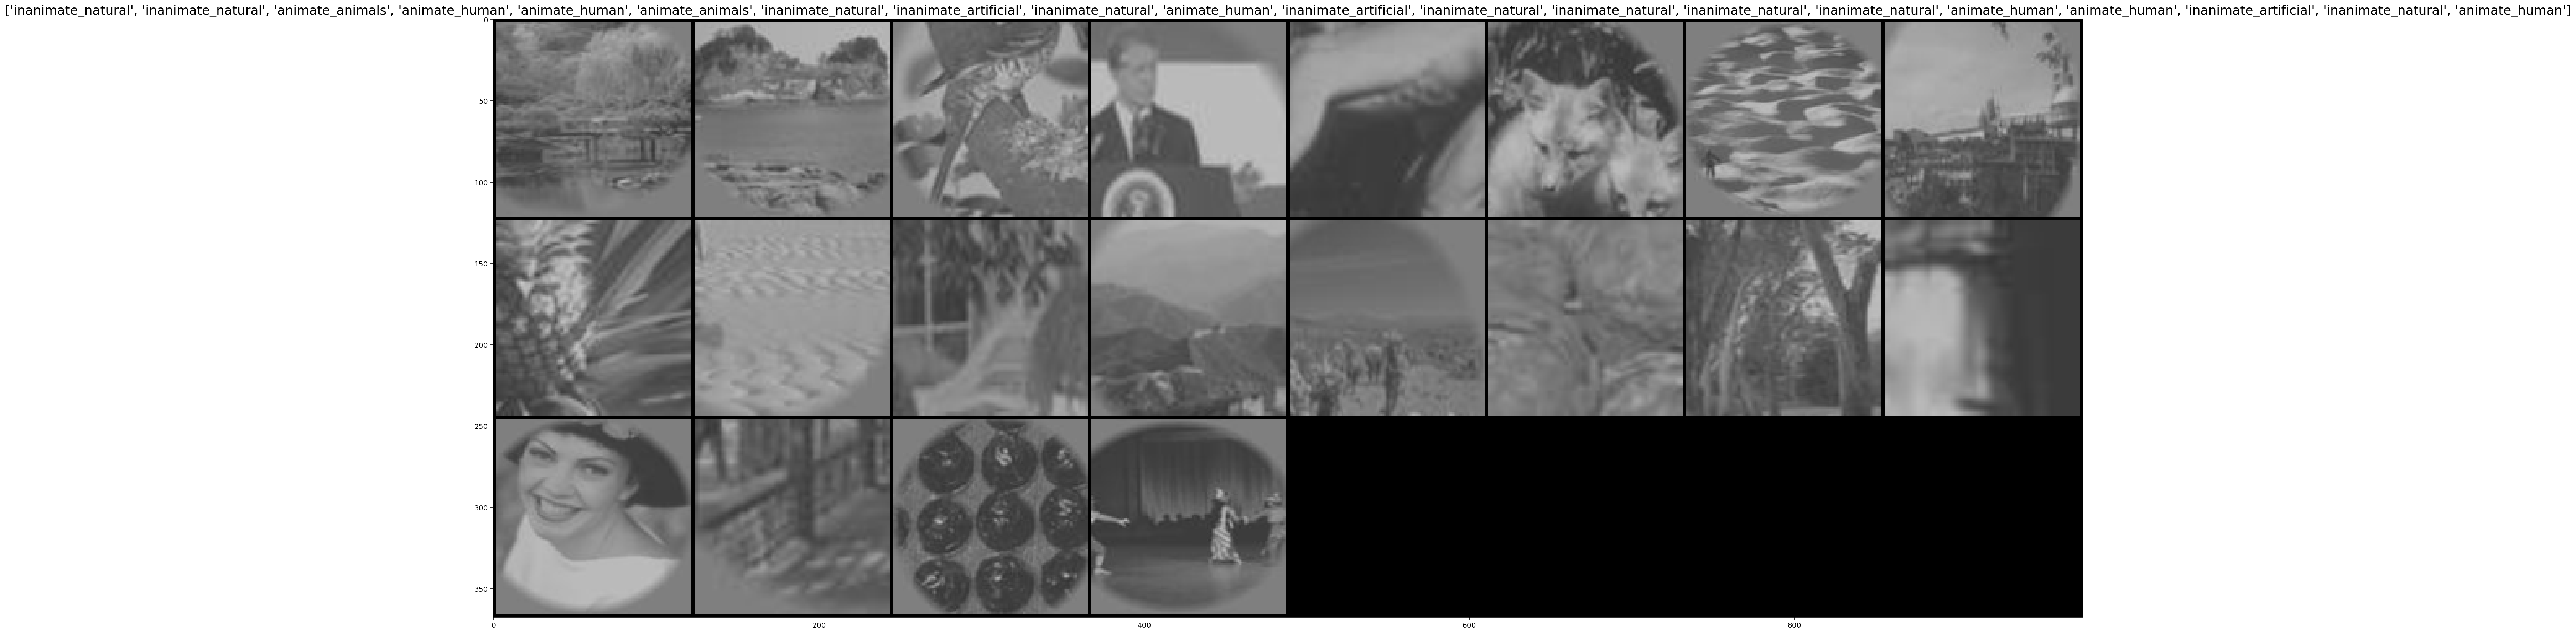

In [ ]:
#@title Visualize a few images

def imshow(inp, title=None, figsize=[40, 25]):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        xx, yy = torch.utils.data.random_split(stim_datasets, [dataset_sizes['train'], dataset_sizes['val']])

        dataloaders = {
            'train': torch.utils.data.DataLoader(xx, batch_size=batch_size, shuffle=True, num_workers=8),
            'val': torch.utils.data.DataLoader(yy, batch_size=batch_size, shuffle=True, num_workers=8),
        }

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], figsize=[5, 5])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4. 因为我们是4类
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()  #.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1607 Acc: 0.5213
val Loss: 1.2067 Acc: 0.5120

Epoch 1/24
----------
train Loss: 0.7959 Acc: 0.7013
val Loss: 1.1708 Acc: 0.4880

Epoch 2/24
----------
train Loss: 0.6876 Acc: 0.7320
val Loss: 0.8536 Acc: 0.6600

Epoch 3/24
----------
train Loss: 0.6261 Acc: 0.7680
val Loss: 0.8975 Acc: 0.6560

Epoch 4/24
----------
train Loss: 0.5761 Acc: 0.7787
val Loss: 0.7695 Acc: 0.6960

Epoch 5/24
----------
train Loss: 0.5363 Acc: 0.7947
val Loss: 0.7707 Acc: 0.6800

Epoch 6/24
----------
train Loss: 0.5220 Acc: 0.8067
val Loss: 0.6038 Acc: 0.7640

Epoch 7/24
----------
train Loss: 0.4886 Acc: 0.8233
val Loss: 0.3564 Acc: 0.8920

Epoch 8/24
----------
train Loss: 0.4518 Acc: 0.8340
val Loss: 0.3497 Acc: 0.8760

Epoch 9/24
----------
train Loss: 0.4151 Acc: 0.8500
val Loss: 0.4662 Acc: 0.8400

Epoch 10/24
----------
train Loss: 0.4313 Acc: 0.8460
val Loss: 0.3636 Acc: 0.8880

Epoch 11/24
----------
train Loss: 0.3859 Acc: 0.8467
val Loss: 0.4607 Acc: 0.8280

Ep

## eval on test set

In [ ]:
%cd ..
!ls

/content/drive/My Drive
'Analysis of Citation Graphs.ipynb'
'Colab Notebooks'
'Frequently Asked Questions.gdoc'
'How does the brain represent feedback information (1).pptx'
'How does the brain represent feedback information (2).pptx'
'How does the brain represent feedback information.gslides'
'How does the brain represent feedback information.pdf'
'How does the brain represent feedback information.pptx'
 kay
'[NMA Project] Understand the complex response pattern in high-level brain area.pdf'
'Project - understand the complex pattern in high-level brain area_LB.gdoc'
'Project - understand the complex pattern in high-level brain area_LB.pdf'
'Project - understand the complex pattern in high-level brain area.pdf'
 Spezio_NEUR95L_Lab_Session1.gdoc
 stim
 stimuli_test
 test_tranfer
 格言.gdoc
 简历.gdoc


In [ ]:
test_dir = 'stimuli_test'

test_data = datasets.ImageFolder(os.path.join(test_dir), transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=40, shuffle=True, num_workers=1)
test_size = 120

In [ ]:
def eval_model(model, criterion):
    model.eval()  
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.double() / test_size
    print('Acc: {:.4f}'.format(epoch_acc))

In [ ]:
eval_model(model_ft, criterion)

Acc: 0.7583


In [ ]:
visualize_model(model_ft)

FileNotFoundError: ignored

<Figure size 576x432 with 0 Axes>

# 从图片中得到数据和标签


In [ ]:
%cd 'stim'

/content/drive/My Drive/stim


In [ ]:
categories = os.listdir(data_dir)

training_data = [0] * 1750 
training_labels = [0] * 1750 
training_labels_name = [0] * 1750 
labels2num = {str(categories[i]): i for i in range(len(categories))}

for category in categories:
    files = os.listdir(data_dir+'//' + category)
    for file in files:
        training_index = int(file.split("_")[0])
        im = Image.open(data_dir + '//' + category + '//' + file)
        training_data[training_index] = np.array(im)
        training_labels[training_index] = labels2num[category]
        training_labels_name[training_index] = category

training_data = np.array(training_data)
training_labels = np.array(training_labels)
training_data.shape

(1750, 128, 128)

# 把神经网络的representation拿出来看看结果
Goal: extracting our deep CNN model's representations of these same stimuli

We'll run these very same stimuli through our CNN model and use the get_hidden_activity() function to store its internal representations. The output of this function is a Python dict, which contains a matrix of population responses (just like resp_v1) for each layer of the network specified by the layer_labels argument. 



In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_hidden_activity(net, stimuli):
    """Retrieve internal representations of network

    Args:
      net (nn.Module): a NN model
      stimuli (torch.Tensor): batchsize x 1 x 128 x 128 tensor 

    Returns:
      dict: internal representations at each layer of the network, in
        numpy arrays. The keys of this dict are the strings in layer_labels.

    """
    feature_out = {}
    layers_name = list(net._modules.keys())
    layers = list(net._modules.values())

    def hook_fn_forward(module, input, output):
        # Attach 'hooks' to each layer of the network to store hidden representations in hidden_activity
        layer_name = layers_name[np.argwhere([module == m for m in layers])[0, 0]]
        feature_out[layer_name] = output
    
    handles = {}
    modules = net.named_children()
    for name, module in modules:
        handles[name] = module.register_forward_hook(hook_fn_forward)

    net.eval() 
    with torch.no_grad():
        pred = net(stimuli)
        for k, v in handles.items():
            handles[k].remove()
            
    return feature_out

In [ ]:
# stimuli to get hidden activity
x = torch.from_numpy(training_data)
x = x.unsqueeze(1)
x = x.float()
x = x.to(device)
x.shape

torch.Size([1750, 1, 128, 128])

In [ ]:
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.to(device)
1

1

In [ ]:
hidden_activity = get_hidden_activity(model_ft, x)
print(hidden_activity.keys())
print(hidden_activity['conv1'].shape)

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])
torch.Size([1750, 64, 64, 64])


In [ ]:
# np.save("output.npy", hidden_activity)
# torch.save(hidden_activity, 'hidden_activity.pt')

In [ ]:
!ls

In [ ]:
hidden_activity['conv1'][0].shape

# Visualize CNN

##  the activation map for a certain input

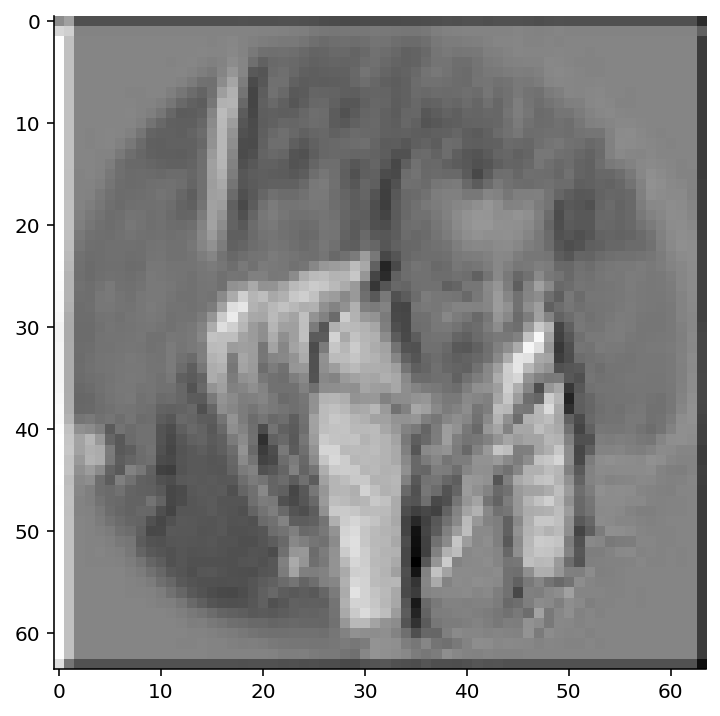

In [ ]:
plt.imshow(hidden_activity['conv1'][0][62].cpu().numpy(), cmap='gray')

In [ ]:
hidden_activity['layer1'].shape

torch.Size([1750, 64, 32, 32])

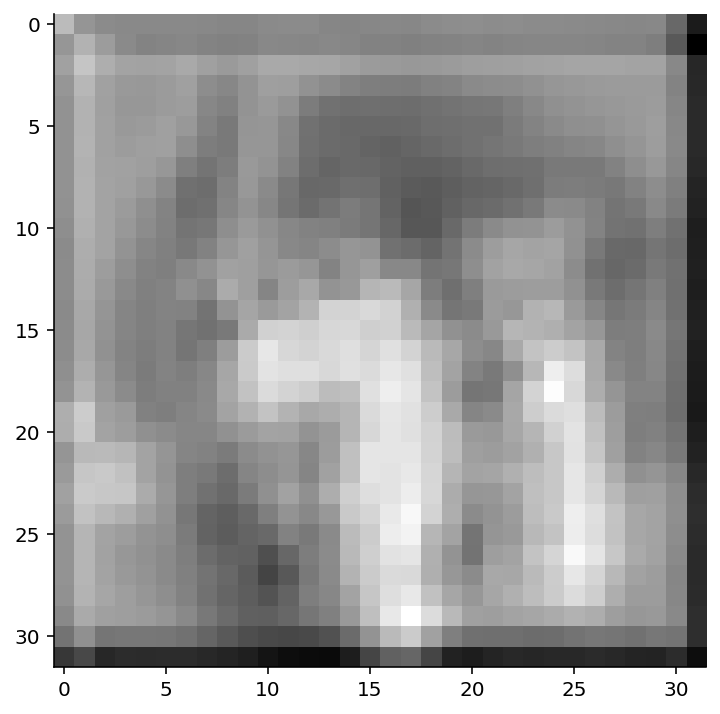

In [ ]:
plt.imshow(hidden_activity['layer1'][0][0].cpu().numpy(), cmap='gray')

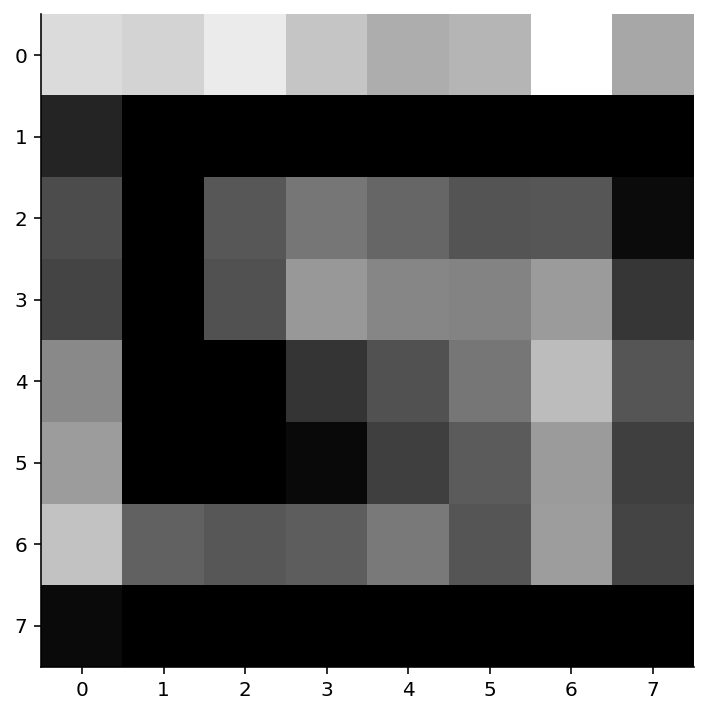

In [ ]:
plt.imshow(hidden_activity['layer3'][0][5].cpu().numpy(), cmap='gray')

## visualize filter


In [ ]:
filter_conv1 = model_ft.conv1.weight.detach().cpu().numpy().squeeze(1)
filter_conv1.shape

(64, 7, 7)

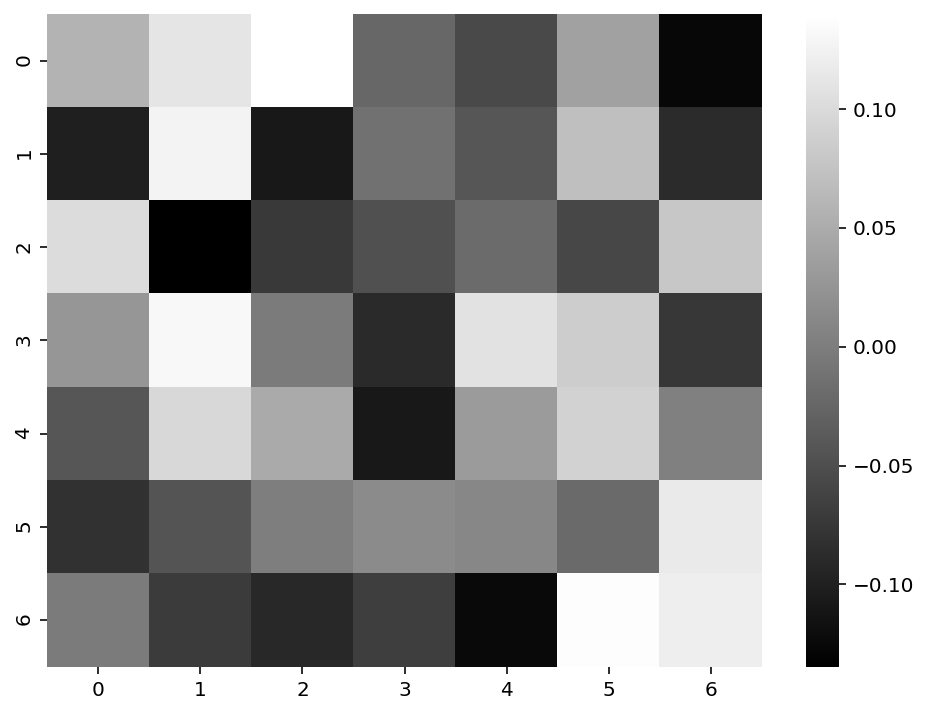

In [ ]:
sns.heatmap(filter_conv1[63], cmap='gray')

In [ ]:
filter_layer1 = model_ft.layer1[0].conv1.weight.detach().cpu().numpy()
filter_layer1.shape

(64, 64, 3, 3)

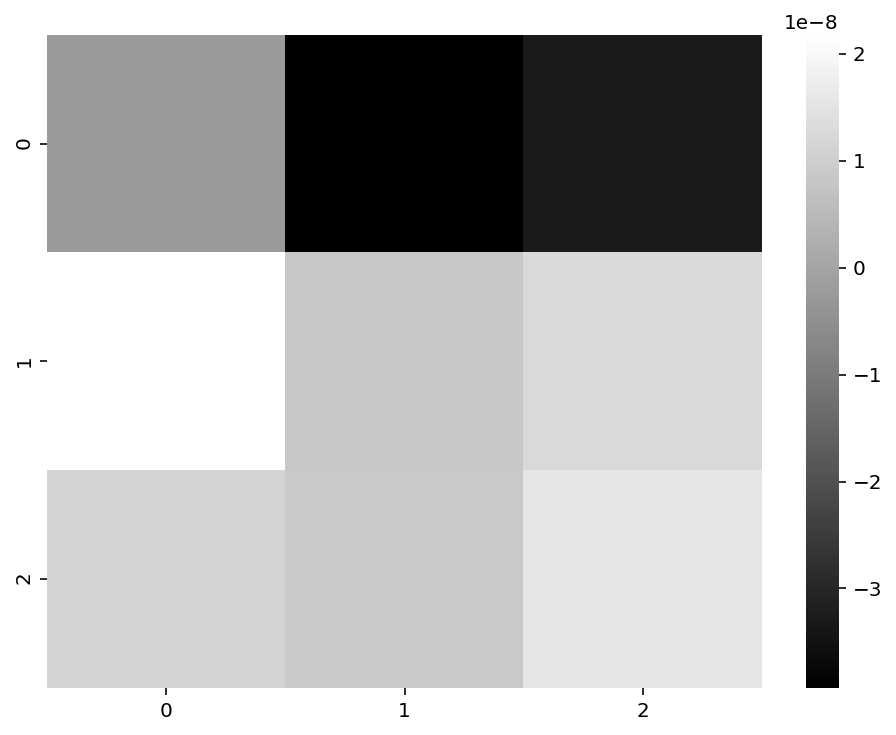

In [ ]:
sns.heatmap(filter_layer1[0,2, :, :], cmap='gray')

In [ ]:
"""
Created on Thu Oct 26 11:06:51 2017
@author: Utku Ozbulak - github.com/utkuozbulak
"""
from PIL import Image
import numpy as np
import torch

from misc_functions import get_example_params, save_class_activation_images


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam


if __name__ == '__main__':
    # Get params
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Grad cam
    grad_cam = GradCam(pretrained_model, target_layer=11)
    # Generate cam mask
    cam = grad_cam.generate_cam(prep_img, target_class)
    # Save mask
    save_class_activation_images(original_image, cam, file_name_to_export)
    print('Grad cam completed')

## RDM
RDM 我写了两种方法，一种是用相关算的，一种用距离算的。

In [ ]:
def plot_corr_matrix(rdm, ax=None, vmax=2.0, title=None):
    """Plot dissimilarity matrix

    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity 
        matrix
      ax (matplotlib axes): axes onto which to plot

    Returns:
      nothing
    
    """
    if ax is None:
      ax = plt.gca()

    cax = ax.imshow(rdm, vmin=0.0, vmax=vmax, cmap='YlGn') # YlOrBr YlGn YlGnBu
    ax.set_aspect('auto')
    ax.set_title(title)

    if rdm.shape[0] == 4:
        ax.set_xticks([i for i in range(4)])
        ax.set_yticks([i for i in list(range(4))[::-1]])
        ax_label = [str(i).split('_')[1] for i in list(labels2num.keys())]
        ax.set_xticklabels([ax_label[i] for i in range(4)], rotation=10)
        ax.set_yticklabels([])
        #ax.set_yticklabels([ax_label[i] for i in list(range(4))[::-1]])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = plt.colorbar(cax, ax=ax, label='Euclidian Distance')
    

def RDM(resp, methods='corr'):
    """Compute the representational dissimilarity matrix (RDM)

    Args:
      resp: S x N matrix with population responses to
        each stimulus in each row
    
    Returns:
      np.ndarray: S x S representational dissimilarity matrix
    """
    if methods == 'corr':
        zresp = zscore(resp, axis=1)  # z-score responses to each stimulus
        result = 1 - (zresp @ zresp.T) / zresp.shape[1]
    elif methods == 'dist':
        # pdist just returns the upper triangle of the pairwise distance matrix
        pair_dist = pdist(resp)
        # to get the whole (20, 20) array we can use squareform
        result = squareform(pair_dist)
    return result

In [ ]:
sorted_labels = np.sort(training_labels)

In [ ]:
def transform_resp(layer_name, hidden_activity=hidden_activity):
    # 把hidden activity从GPU取出来，才能转换成numpy数组
    layer_resp = hidden_activity[layer_name].cpu().numpy()
    # 把四维数组变成二维数组
    layer_resp = layer_resp.reshape([1750, -1, 1, 1]) 
    layer_resp = layer_resp.squeeze()
    return layer_resp

In [ ]:
hidden_activity['fc'].shape

torch.Size([1750, 4])

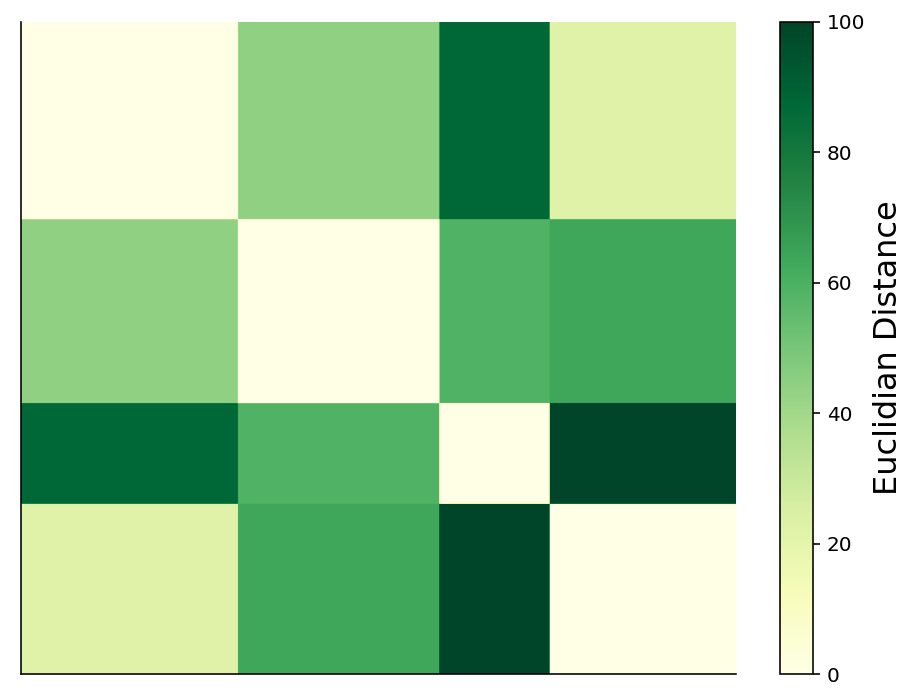

In [ ]:
fc_rdm = RDM(hidden_activity['fc'].cpu().numpy()[sorted_labels], 'dist')
plot_corr_matrix(fc_rdm, vmax=100)

In [ ]:
hidden_activity['avgpool'].shape

torch.Size([1750, 512, 1, 1])

In [ ]:
avgpool_resp = transform_resp('avgpool')
avgpool_rdm = RDM(avgpool_resp[sorted_labels], 'dist')

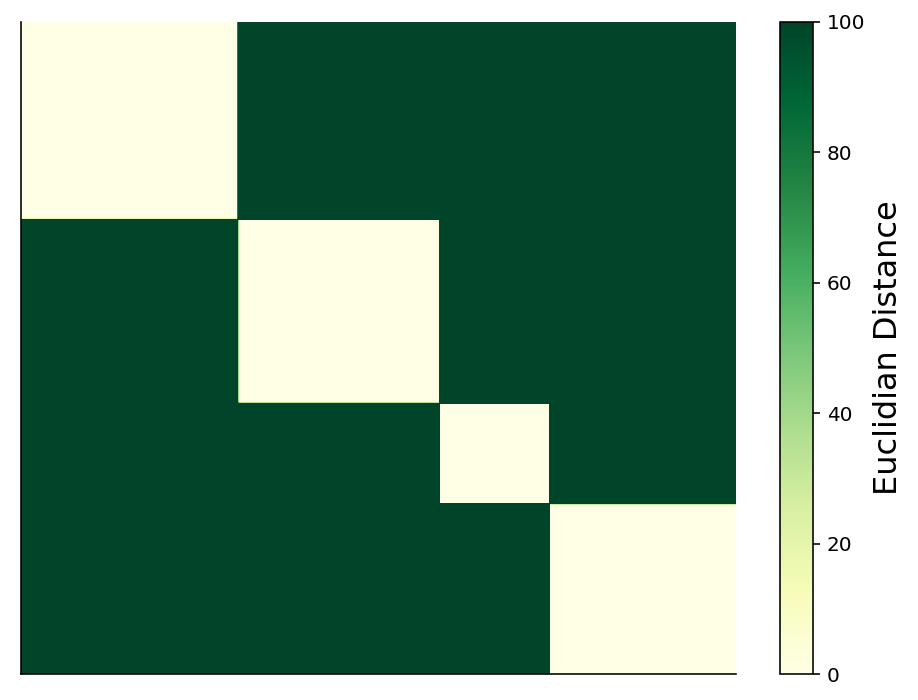

In [ ]:
plot_corr_matrix(avgpool_rdm, vmax=100)

In [ ]:
layer4_resp = transform_resp('layer4')
layer4_rdm = RDM(layer4_resp[sorted_labels], 'dist')

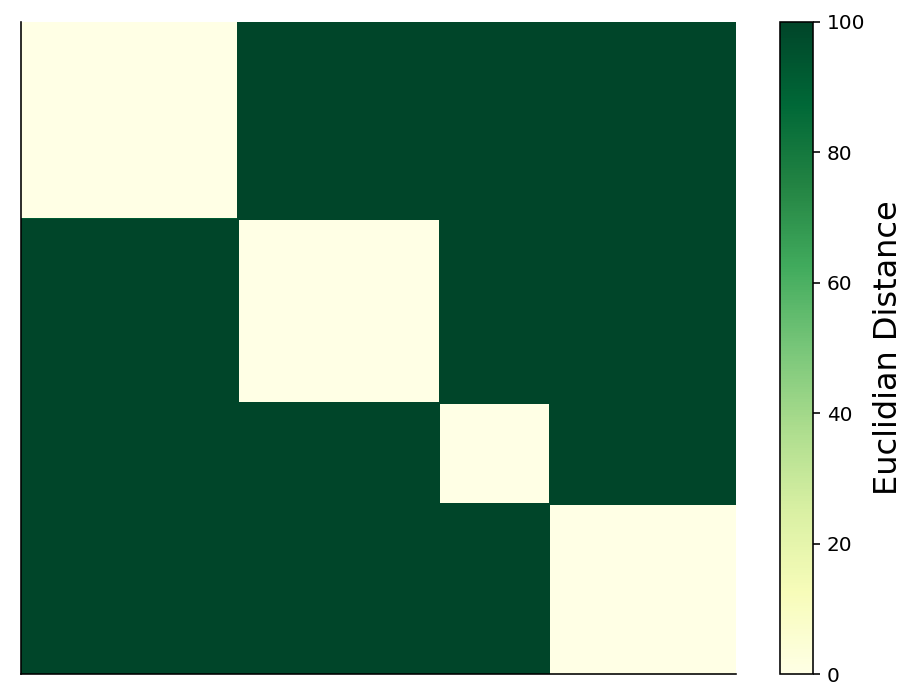

In [ ]:
plot_corr_matrix(layer4_rdm, vmax=100)

In [ ]:
conv1_resp = transform_resp('conv1')
conv1_rdm = RDM(conv1_resp[sorted_labels], 'dist')

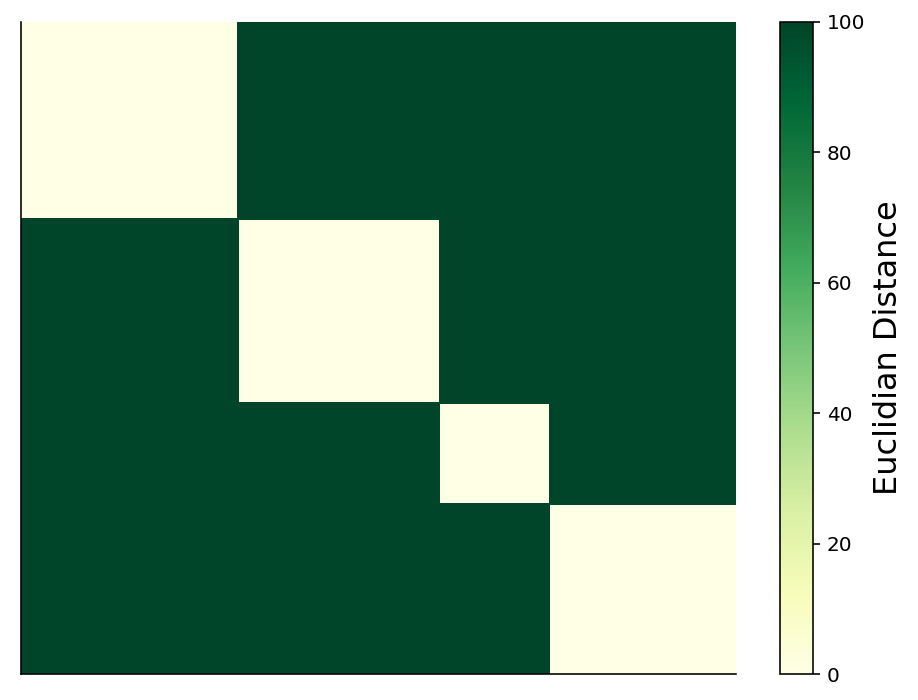

In [ ]:
plot_corr_matrix(conv1_rdm, vmax=100)

In [ ]:
maxpool_resp = transform_resp('maxpool')
maxpool_rdm = RDM(maxpool_resp[sorted_labels], 'dist')

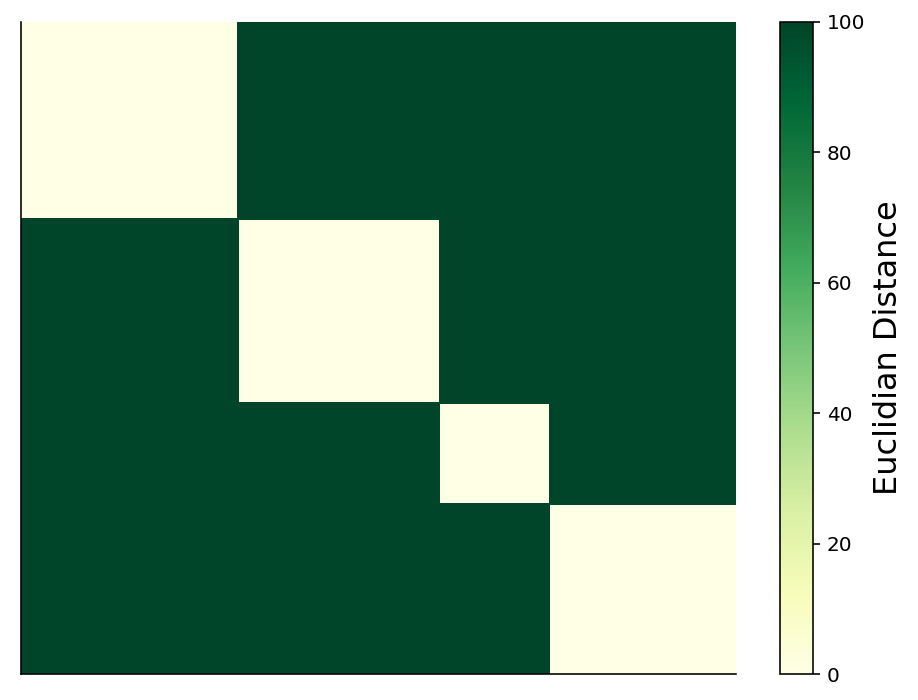

In [ ]:
plot_corr_matrix(maxpool_rdm, vmax=100)

In [ ]:
layer1_resp = transform_resp('layer1')
layer1_resp.shape
#layer1_rdm = RDM(layer1_resp[sorted_labels], 'dist')

(1750, 65536)

In [ ]:
layer2_resp = transform_resp('layer2')
layer2_resp.shape
layer2_rdm = RDM(layer2_resp[sorted_labels], 'dist')

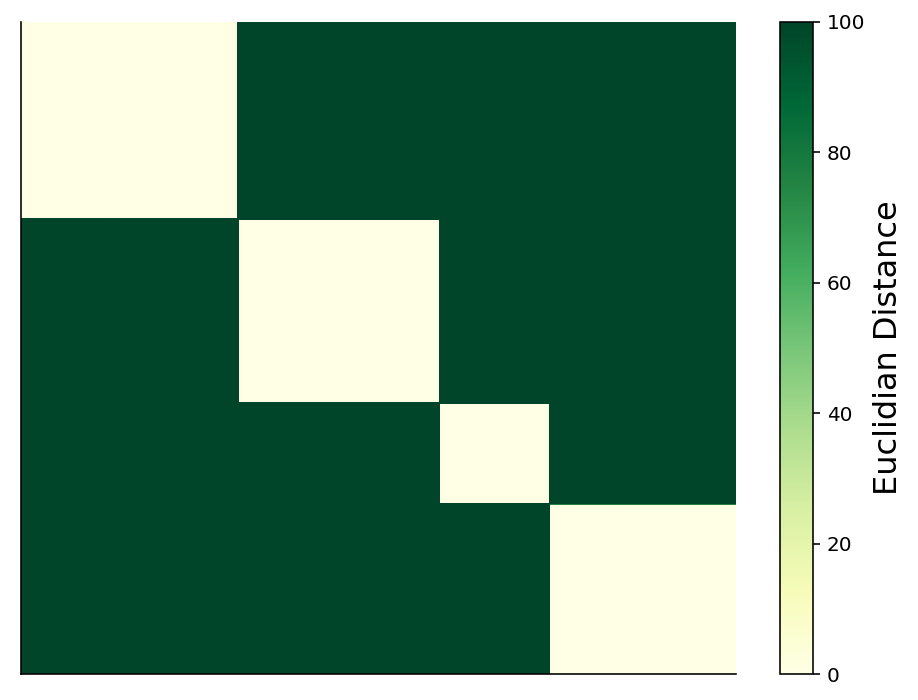

In [ ]:
plot_corr_matrix(layer2_rdm, vmax=100)

In [ ]:
layer3_resp = transform_resp('layer3')
layer3_resp.shape
layer3_rdm = RDM(layer3_resp[sorted_labels], 'dist')

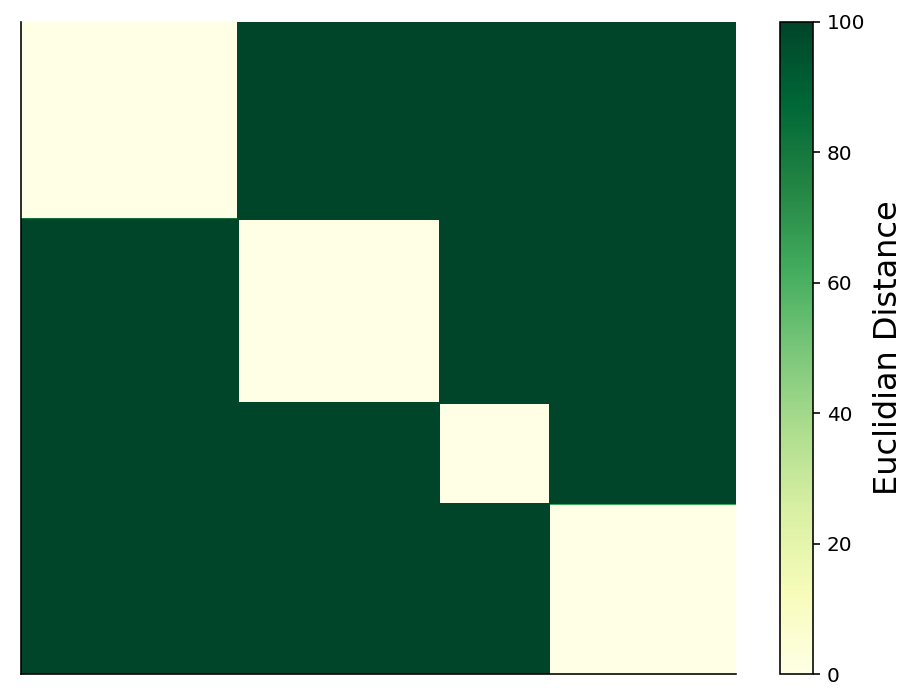

In [ ]:
plot_corr_matrix(layer3_rdm, vmax=100)

# 下面代码无法运行


## 降维可视化


In [ ]:
# 还需要降维，不然有的没法运算
ipca = IncrementalPCA(n_components=200, batch_size=200)
transformer.partial_fit(X[:100, :])

NameError: ignored

In [ ]:
ipca.fit(conv1_resp)

In [ ]:
transformer.partial_fit(X[:100, :])

In [ ]:
ipca = IncrementalPCA(n_components=500, batch_size=500)

In [ ]:
conv1_resp_lowd = ipca.fit_transform(conv1_resp)